# ICC Pipeline Demo: Step-by-Step Walkthrough

This notebook demonstrates the **Iterative Cluster-Critic (ICC)** framework for unsupervised entity type discovery.

## Overview

The ICC pipeline consists of:
1. **Module I**: Mention Detection (already completed via `Entity-Detection`)
2. **Module II**: Contextual Embedding & Initial Clustering (Dip-means)
3. **Module III**: Critic-Based Refinement Loop (merge/split via confusion matrix)
4. **Module IV**: Semantic Naming (LLM-based, demonstrated with examples)

## Prerequisites

- Spans already detected by `Entity-Detection` and combined into `Type-Prediction/dataset/<target>_<split>.json` with `tags_ner_pred`
- Required packages: `transformers`, `torch`, `scikit-learn`, `numpy`
- GPU optional but recommended for faster encoding



In [1]:
# Install required packages (if needed)
# !pip install transformers torch scikit-learn numpy

In [2]:
# !pip install scikit-learn 


## Step 1: Setup and Imports


In [1]:
import json
import os
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split

# Import ICC pipeline components (modularized under icc/)
import sys
sys.path.append(str(Path.cwd()))
from icc.encoding import MentionEncoder
from icc.clustering import DipMeans
from icc.critic import CriticRefiner
from icc.data_utils import load_mentions, select_examples

# Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.5.1+cu121


In [4]:
# !pip uninstall -y numpy scipy scikit-learn
# !pip install --no-cache-dir --force-reinstall "numpy==1.26.4" "scipy==1.11.4" "scikit-learn==1.3.2"

## Step 1.5: Configure Paths and Parameters


In [2]:
# Configure paths and parameters
TARGET = "politics"
SPLIT = "dev"  # dev or test
DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/dataset") / f"{TARGET}_{SPLIT}.json"
OUTPUT_DIR = Path("outputs") / f"icc_{TARGET}_{SPLIT}_demo"
MODEL_NAME = "bert-base-cased"  # Encoder model

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model: {MODEL_NAME}")
print(f"Dataset exists: {DATASET_PATH.exists()}")

if not DATASET_PATH.exists():
    print(f"\n⚠️  WARNING: Dataset file not found!")
    print(f"   Please ensure Entity-Detection has been run and spans are combined.")
    print(f"   Expected format: {DATASET_PATH}")


Dataset path: ../DTrans-MPrompt/Type-Prediction/dataset/politics_dev.json
Output directory: outputs/icc_politics_dev_demo
Model: bert-base-cased
Dataset exists: True


## Step 2: Load Detected Mentions

Load the entity spans that were detected by Module I (Entity-Detection).


In [3]:
# Load mentions from the dataset
mentions = load_mentions(str(DATASET_PATH))

print(f"Loaded {len(mentions)} mentions")
print(f"\nFirst 5 mentions:")
for i, m in enumerate(mentions[:5]):
    print(f"  {i+1}. Span ID: {m.span_id}, Text: '{m.text[:50]}...'")
    print(f"     Context: '{m.context[:80]}...'")


Loaded 3504 mentions

First 5 mentions:
  1. Span ID: (0, 14, 17), Text: 'Italian Democratic Socialists...'
     Context: 'At the 2001 Italian general election the Greens formed a joint list with the Ita...'
  2. Span ID: (0, 2, 6), Text: '2001 Italian general election...'
     Context: 'At the 2001 Italian general election the Greens formed a joint list with the Ita...'
  3. Span ID: (0, 21, 23), Text: 'The Sunflower...'
     Context: 'At the 2001 Italian general election the Greens formed a joint list with the Ita...'
  4. Span ID: (0, 18, 19), Text: 'SDI...'
     Context: 'At the 2001 Italian general election the Greens formed a joint list with the Ita...'
  5. Span ID: (0, 7, 8), Text: 'Greens...'
     Context: 'At the 2001 Italian general election the Greens formed a joint list with the Ita...'


## Step 3: Module II - Contextual Embedding

Encode each mention using prompt-based encoding: `"<context> [SEP] <mention> is a [MASK]"`

The embedding at the `[MASK]` position captures the semantic type information.


In [6]:
# Initialize encoder
print(f"Loading encoder model: {MODEL_NAME}")
encoder = MentionEncoder(model_name=MODEL_NAME, device=DEVICE)
print("Encoder loaded successfully!")

# Encode all mentions
print(f"\nEncoding {len(mentions)} mentions...")
X = encoder.encode(mentions, batch_size=16)

print(f"Embedding shape: {X.shape}")
print(f"Embedding dtype: {X.dtype}")
print(f"Sample embedding (first 10 dims): {X[0][:10]}")


Loading encoder model: bert-base-cased


/home/smallp/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoder loaded successfully!

Encoding 3504 mentions...
Embedding shape: (3504, 768)
Embedding dtype: float32
Sample embedding (first 10 dims): [ 0.08964206 -0.09892546 -0.77082866 -0.1158293  -0.05364872 -0.08603293
  0.08606923 -0.07004251  0.03466811 -0.32040918]


## Step 4: Module II - Initial Clustering with Dip-means

Dip-means adaptively discovers the number of clusters by recursively splitting clusters that exhibit multimodality.

**Algorithm:**
1. Start with a single cluster containing all mentions
2. For each cluster, test if it's multimodal using a projection-based test
3. If multimodal, split into 2 sub-clusters using K-means
4. Repeat until no more splits are needed


In [8]:
# Initialize Dip-means clustering
dip = DipMeans(alpha=0.05, min_size=10)

print("Running Dip-means clustering...")
print("This may take a few minutes depending on dataset size...")

init_labels = dip.fit_predict(X)

# Analyze initial clusters
unique_labels, counts = np.unique(init_labels, return_counts=True)
print(f"\nInitial clustering complete!")
print(f"Number of clusters discovered: {len(unique_labels)}")
print(f"Cluster sizes: min={counts.min()}, max={counts.max()}, mean={counts.mean():.1f}")
print(f"\nCluster distribution:")
for label, count in zip(unique_labels[:10], counts[:10]):
    print(f"  Cluster {label}: {count} mentions")
if len(unique_labels) > 10:
    print(f"  ... and {len(unique_labels) - 10} more clusters")


Running Dip-means clustering...
This may take a few minutes depending on dataset size...

Initial clustering complete!
Number of clusters discovered: 63
Cluster sizes: min=3, max=575, mean=55.6

Cluster distribution:
  Cluster 8: 121 mentions
  Cluster 11: 80 mentions
  Cluster 18: 575 mentions
  Cluster 21: 59 mentions
  Cluster 23: 128 mentions
  Cluster 25: 37 mentions
  Cluster 31: 85 mentions
  Cluster 34: 254 mentions
  Cluster 39: 38 mentions
  Cluster 43: 4 mentions
  ... and 53 more clusters


## Step 5: Module III - Critic-Based Refinement Loop

The refinement loop uses a classifier (Critic) to identify:
- **Merge candidates**: Clusters that are frequently confused (likely same semantic type)
- **Split candidates**: Clusters with low internal consistency (likely mixed types)

**Process:**
1. Train a classifier on current cluster assignments
2. Evaluate on validation set to get confusion matrix
3. Compute metrics:
   - **SCS (Symmetric Confusion Score)**: $$\frac{(M_{ij} + M_{ji})} {(|c_i| + |c_j|)}$$ for merge decisions
   - **ICS (Internal Confidence Score)**: $$\frac{M_{ii}} {|c_i|}$$ for split decisions
4. Apply merge/split operations
5. Repeat until convergence or max iterations


In [9]:
# Initialize Critic Refiner
refiner = CriticRefiner(
    tau_merge=0.35,    # Merge threshold: if SCS > 0.35, merge clusters
    tau_split=0.60,    # Split threshold: if ICS < 0.60, split cluster
    max_iter=5,        # Maximum refinement iterations
    min_cluster=5      # Minimum cluster size
)

print("Starting Critic-based refinement loop...")
print(f"Initial clusters: {len(np.unique(init_labels))}")

# Build prompt texts for the critic (matches encoder prompt)
prompt_texts = [
    f"{m.context} {encoder.tokenizer.sep_token} {m.text} is a {encoder.tokenizer.mask_token}"
    for m in mentions
]

# Run refinement (needs embeddings, initial labels, and texts)
refined_labels = refiner.refine(X, init_labels, prompt_texts)

# Analyze refined clusters
unique_refined, counts_refined = np.unique(refined_labels, return_counts=True)
print(f"\nRefinement complete!")
print(f"Final clusters: {len(unique_refined)}")
print(f"Cluster sizes: min={counts_refined.min()}, max={counts_refined.max()}, mean={counts_refined.mean():.1f}")

# Compare before/after
print(f"\nComparison:")
print(f"  Initial clusters: {len(unique_labels)}")
print(f"  Final clusters: {len(unique_refined)}")
print(f"  Change: {len(unique_refined) - len(unique_labels):+d}")


Starting Critic-based refinement loop...
Initial clusters: 63


/home/smallp/miniconda3/envs/dtrans/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/smallp/miniconda3/envs/dtrans/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin


Refinement complete!
Final clusters: 72
Cluster sizes: min=3, max=575, mean=48.7

Comparison:
  Initial clusters: 63
  Final clusters: 72
  Change: +9


## Step 6: Visualize Cluster Examples

For each cluster, we select:
- **Centroids**: 5 mentions closest to cluster center (core examples)
- **Boundaries**: 5 mentions furthest from center (edge cases)

These examples will be used for semantic naming in Module IV.


In [10]:
# Select examples for each cluster
examples = select_examples(X, mentions, refined_labels, k=5)

print(f"Selected examples for {len(examples)} clusters\n")
print("=" * 80)

# Display examples for first few clusters
for cluster_id in sorted(examples.keys())[:5]:
    ex = examples[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Centroids (core examples):")
    for i, text in enumerate(ex["centroids"], 1):
        print(f"    {i}. {text}")
    if ex["boundaries"]:
        print(f"  Boundaries (edge cases):")
        for i, text in enumerate(ex["boundaries"], 1):
            print(f"    {i}. {text}")
    print("-" * 80)


Selected examples for 72 clusters


Cluster 0:
  Centroids (core examples):
    1. 1923 United Kingdom general election
    2. 1966 United Kingdom general election
    3. 1966 United Kingdom general election
    4. 1970 United Kingdom general election
    5. 1970 United Kingdom general election
  Boundaries (edge cases):
    1. 2019 United Kingdom general election
    2. 1935 New South Wales state election
    3. 2019 United Kingdom general election
    4. West Aberdeenshire
    5. East Aberdeenshire
--------------------------------------------------------------------------------

Cluster 1:
  Centroids (core examples):
    1. Amey Wagh
    2. Jatin Sarna
    3. Neeraj Kabi
    4. Karan Wahi
    5. Aamir Bashir
  Boundaries (edge cases):
    1. Radha Ravi
    2. RuPaul
    3. Ben Platt
    4. Gwyneth Paltrow
    5. Barbra Streisand
--------------------------------------------------------------------------------

Cluster 2:
  Centroids (core examples):
    1. World War I
    2. World Wa

## Step 7: Save Results

Save cluster assignments and examples for downstream use (e.g., semantic naming).


In [11]:
# Save cluster assignments
clusters_out = [
    {
        "span_id": mentions[i].span_id,
        "text": mentions[i].text,
        "context": mentions[i].context,
        "cluster": int(refined_labels[i])
    }
    for i in range(len(mentions))
]

clusters_file = OUTPUT_DIR / "clusters.json"
with open(clusters_file, "w", encoding="utf-8") as f:
    json.dump(clusters_out, f, indent=2, ensure_ascii=False)

print(f"Saved cluster assignments to: {clusters_file}")
print(f"  Total mentions: {len(clusters_out)}")
print(f"  Total clusters: {len(np.unique(refined_labels))}")

# Save examples for naming
examples_file = OUTPUT_DIR / "cluster_examples.json"
with open(examples_file, "w", encoding="utf-8") as f:
    json.dump(examples, f, indent=2, ensure_ascii=False)

print(f"\nSaved cluster examples to: {examples_file}")
print(f"  Clusters with examples: {len(examples)}")


Saved cluster assignments to: outputs/icc_politics_dev_demo/clusters.json
  Total mentions: 3504
  Total clusters: 72

Saved cluster examples to: outputs/icc_politics_dev_demo/cluster_examples.json
  Clusters with examples: 72


## Step 8: Module IV - Semantic Naming (Example)

Generate semantic names for clusters using LLM prompting. Here we show the prompt structure that would be sent to an LLM (e.g., GPT-4).

**Note**: This is a demonstration. For actual LLM calls, you would use an API like OpenAI or a local model.


In [12]:
def generate_naming_prompt(cluster_id: int, examples: Dict) -> str:
    """Generate prompt for LLM-based semantic naming."""
    ex = examples[cluster_id]
    centroids_str = ", ".join(ex["centroids"])
    boundaries_str = ", ".join(ex["boundaries"]) if ex["boundaries"] else "N/A"
    
    prompt = f"""You are an expert taxonomist. I will provide a list of entities that belong to the same category.

Core Examples: {centroids_str}
Edge Examples: {boundaries_str}

Identify the single most specific semantic category that encompasses all these examples. Return only the category name."""
    
    return prompt

# Generate prompts for first few clusters
print("Example naming prompts:\n")
print("=" * 80)

for cluster_id in sorted(examples.keys())[:3]:
    prompt = generate_naming_prompt(cluster_id, examples)
    print(f"\nCluster {cluster_id} Prompt:")
    print("-" * 80)
    print(prompt)
    print("=" * 80)


Example naming prompts:


Cluster 0 Prompt:
--------------------------------------------------------------------------------
You are an expert taxonomist. I will provide a list of entities that belong to the same category.

Core Examples: 1923 United Kingdom general election, 1966 United Kingdom general election, 1966 United Kingdom general election, 1970 United Kingdom general election, 1970 United Kingdom general election
Edge Examples: 2019 United Kingdom general election, 1935 New South Wales state election, 2019 United Kingdom general election, West Aberdeenshire, East Aberdeenshire

Identify the single most specific semantic category that encompasses all these examples. Return only the category name.

Cluster 1 Prompt:
--------------------------------------------------------------------------------
You are an expert taxonomist. I will provide a list of entities that belong to the same category.

Core Examples: Amey Wagh, Jatin Sarna, Neeraj Kabi, Karan Wahi, Aamir Bashir
Edge Exa

## Step 8.5: Semantic Naming with Ollama (Module IV)

Use the generated centroids/boundaries to build prompts and (optionally) send them to a local Ollama model to get cluster names.


In [13]:
from icc.naming import build_prompts, call_ollama, save_prompts

# Build prompts from the selected examples
prompts = build_prompts(examples)
prompts_path = OUTPUT_DIR / "naming_prompts.json"
save_prompts(prompts, prompts_path)
print(f"Saved naming prompts to: {prompts_path}")

# Optionally, call a local Ollama model to get names
# Set OLLAMA_MODEL to your local model name (e.g., "llama3", "mistral")
OLLAMA_MODEL = "llama3.1:70b"  # change to model name to enable

if OLLAMA_MODEL:
    print(f"Running prompts through Ollama model: {OLLAMA_MODEL}")
    naming_results = call_ollama(prompts, OLLAMA_MODEL, examples)
    
    results_path = OUTPUT_DIR / "naming_results.json"
    import json
    with open(results_path, "w", encoding="utf-8") as f:
        json.dump(naming_results, f, indent=2, ensure_ascii=False)
    print(f"Saved naming results to: {results_path}")
else:
    print("Skipping Ollama naming (set OLLAMA_MODEL to enable)")



Saved naming prompts to: outputs/icc_politics_dev_demo/naming_prompts.json
Running prompts through Ollama model: llama3.1:70b
Saved naming results to: outputs/icc_politics_dev_demo/naming_results.json


In [14]:
naming_results

{0: {'centroids': ['1923 United Kingdom general election',
   '1966 United Kingdom general election',
   '1966 United Kingdom general election',
   '1970 United Kingdom general election',
   '1970 United Kingdom general election'],
  'boundaries': ['2019 United Kingdom general election',
   '1935 New South Wales state election',
   '2019 United Kingdom general election',
   'West Aberdeenshire',
   'East Aberdeenshire'],
  'name': 'Uk General Elections'},
 1: {'centroids': ['Amey Wagh',
   'Jatin Sarna',
   'Neeraj Kabi',
   'Karan Wahi',
   'Aamir Bashir'],
  'boundaries': ['Radha Ravi',
   'RuPaul',
   'Ben Platt',
   'Gwyneth Paltrow',
   'Barbra Streisand'],
  'name': 'Indian Television Actors'},
 2: {'centroids': ['World War I',
   'World War I',
   'Reichstag',
   'Ottoman Empire',
   'Turkish War of Independence'],
  'boundaries': ['South Africa Medal',
   'Kannada',
   'Zulu War Medal',
   'The Week Politics Went Tabloid',
   'Grover Cleveland : A Study in Courage'],
  'name': 

In [15]:
print (prompts[0])

You are an expert taxonomist. Your task is to identify the most specific semantic category name for a set of entities.

Guidelines:
- Use a specific, descriptive category name (2-5 words typically)
- Avoid overly generic terms like "Entity", "Thing", "Item"
- Avoid overly specific terms that include location/time unless necessary
- The name should be a noun phrase that clearly describes what all examples have in common

Examples:
Core: ["Barack Obama", "George W. Bush", "Bill Clinton"] → "US Presidents"
Core: ["World War I", "World War II", "Korean War"] → "Wars"
Core: ["New York", "California", "Texas"] → "US States"
Core: ["Republican Party", "Democratic Party", "Green Party"] → "Political Parties"

Now, provide a category name for:
Core Examples: 1923 United Kingdom general election, 1966 United Kingdom general election, 1966 United Kingdom general election, 1970 United Kingdom general election, 1970 United Kingdom general election
Edge Examples (less typical): 2019 United Kingdom g

In [16]:
import subprocess
results = {}
prompt = prompts[0]
full_prompt = prompt + "\n\nReturn only the category name, no quotes, no extra text."
model = "llama3:8b"
proc = subprocess.run(
            ["ollama", "run", model],
            input=full_prompt,
            text=True,
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE,
            check=True,
        )
output = proc.stdout.strip()
# Clean ANSI sequences and pick first non-empty line
cleaned_lines = [
    line for line in output.splitlines()
    if line.strip() and not line.startswith("\x1b")
]
name = cleaned_lines[0] if cleaned_lines else ""


## Step 9: Summary Statistics

Compute and display summary statistics about the discovered clusters.


In [17]:
# Compute summary statistics
unique_labels_final, counts_final = np.unique(refined_labels, return_counts=True)

print("=" * 80)
print("FINAL CLUSTERING SUMMARY")
print("=" * 80)
print(f"\nTotal mentions processed: {len(mentions)}")
print(f"Total clusters discovered: {len(unique_labels_final)}")
print(f"\nCluster size statistics:")
print(f"  Minimum: {counts_final.min()}")
print(f"  Maximum: {counts_final.max()}")
print(f"  Mean: {counts_final.mean():.2f}")
print(f"  Median: {np.median(counts_final):.2f}")
print(f"  Std Dev: {counts_final.std():.2f}")

# Show distribution
print(f"\nCluster size distribution:")
size_bins = [0, 5, 10, 20, 50, 100, float('inf')]
bin_labels = ["1-4", "5-9", "10-19", "20-49", "50-99", "100+"]
for i in range(len(size_bins) - 1):
    count = np.sum((counts_final >= size_bins[i]) & (counts_final < size_bins[i+1]))
    if count > 0:
        print(f"  {bin_labels[i]}: {count} clusters")

# Show largest clusters
print(f"\nTop 5 largest clusters:")
top_indices = np.argsort(counts_final)[::-1][:5]
for idx in top_indices:
    cluster_id = unique_labels_final[idx]
    size = counts_final[idx]
    ex = examples.get(cluster_id, {})
    sample_texts = ex.get("centroids", [])[:3]
    print(f"  Cluster {cluster_id}: {size} mentions")
    if sample_texts:
        print(f"    Examples: {', '.join(sample_texts)}")

print("\n" + "=" * 80)


FINAL CLUSTERING SUMMARY

Total mentions processed: 3504
Total clusters discovered: 72

Cluster size statistics:
  Minimum: 3
  Maximum: 575
  Mean: 48.67
  Median: 24.00
  Std Dev: 74.51

Cluster size distribution:
  1-4: 3 clusters
  5-9: 8 clusters
  10-19: 13 clusters
  20-49: 27 clusters
  50-99: 13 clusters
  100+: 8 clusters

Top 5 largest clusters:
  Cluster 2: 575 mentions
    Examples: World War I, World War I, Reichstag
  Cluster 7: 254 mentions
    Examples: Liberal Party, IDS, PSI
  Cluster 4: 128 mentions
    Examples: William Craig, Peter Robinson, John Dunlop
  Cluster 0: 121 mentions
    Examples: 1923 United Kingdom general election, 1966 United Kingdom general election, 1966 United Kingdom general election
  Cluster 14: 119 mentions
    Examples: Christian Coalition of America, Foundation for Moral Law, Southwest Voter Registration Education Project



## Step 10: Optional - Visualization

Visualize clusters using PCA (2D projection) for inspection.


Matplotlib version: 3.10.8
Saved visualization to: outputs/icc_politics_dev_demo/cluster_visualization.png


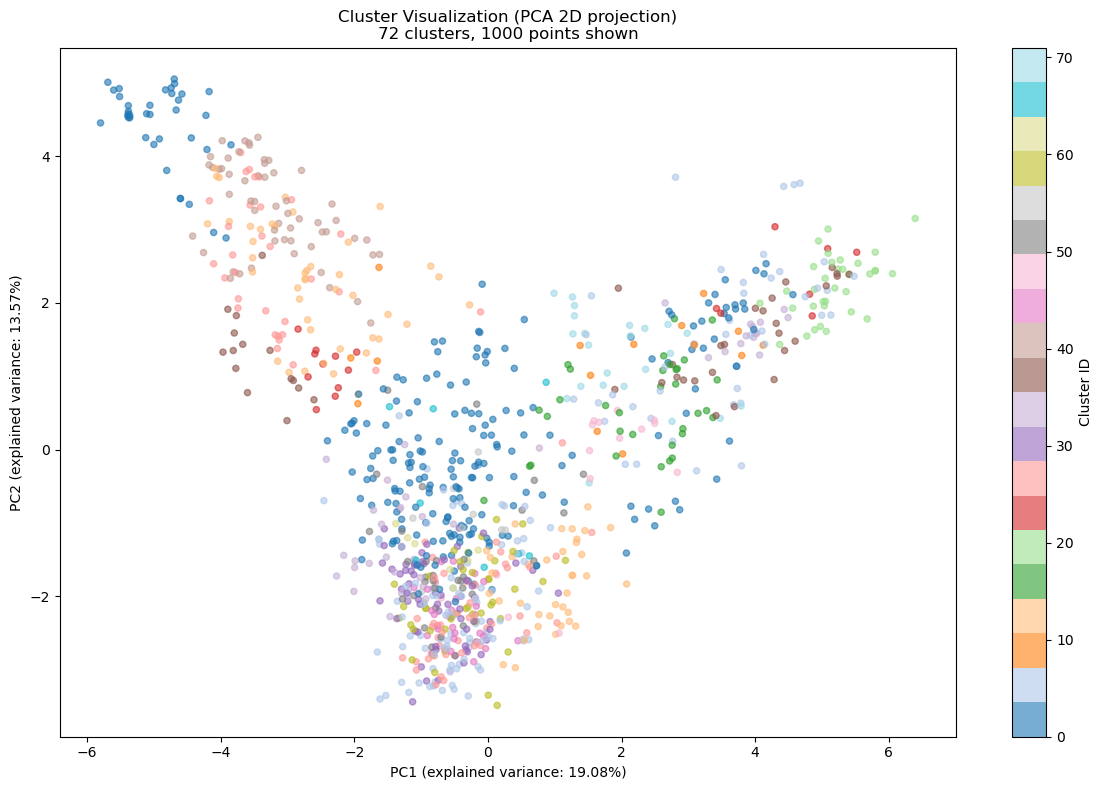

In [18]:
# Optional: 2D visualization using PCA
try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    print(f"Matplotlib version: {getattr(mpl, '__version__', 'unknown')}")
    missing_data_path = not hasattr(mpl, "get_data_path")
    if missing_data_path:
        print("Matplotlib install is missing get_data_path; skipping visualization.")
        print("Try reinstalling: pip install --force-reinstall matplotlib")
    else:
        # Project to 2D for visualization
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        
        # Plot clusters (sample if too many points)
        max_points = 1000
        if len(X_2d) > max_points:
            indices = np.random.choice(len(X_2d), max_points, replace=False)
            X_plot = X_2d[indices]
            labels_plot = refined_labels[indices]
        else:
            X_plot = X_2d
            labels_plot = refined_labels
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            X_plot[:, 0], X_plot[:, 1], c=labels_plot,
            cmap='tab20', alpha=0.6, s=20
        )
        plt.colorbar(scatter, label='Cluster ID')
        plt.title(
            f'Cluster Visualization (PCA 2D projection)\n'
            f'{len(unique_labels_final)} clusters, {len(X_plot)} points shown'
        )
        plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})')
        plt.tight_layout()
        
        viz_file = OUTPUT_DIR / "cluster_visualization.png"
        plt.savefig(viz_file, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to: {viz_file}")
        plt.show()

except ImportError as e:
    print(f"Matplotlib not available ({e}). Skipping visualization.")
except Exception as e:
    print(f"Visualization failed: {e}")


## Next Steps

1. **Review cluster examples**: Check `cluster_examples.json` to verify cluster quality
2. **Semantic naming**: Use the generated prompts with an LLM to assign names to clusters
3. **Evaluation**: Compare discovered clusters against ground truth (if available) using metrics like:
   - Adjusted Mutual Information (AMI)
   - Mapping-based F1 score
   - Silhouette score
4. **Iteration**: Adjust hyperparameters (`tau_merge`, `tau_split`, `alpha`) if needed

## Output Files

- `clusters.json`: Full cluster assignments for all mentions
- `cluster_examples.json`: Examples (centroids/boundaries) for each cluster
- `cluster_visualization.png`: 2D PCA visualization (if matplotlib available)


In [19]:
# 1) Configure paths
TARGET = "politics"
SPLIT = "dev"  # dev or test
DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/dataset") / f"{TARGET}_{SPLIT}.json"
OUTPUT_DIR = Path("outputs") / f"icc_{TARGET}_{SPLIT}_demo"
MODEL_NAME = "bert-base-cased"  # change if desired
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATASET_PATH


PosixPath('../DTrans-MPrompt/Type-Prediction/dataset/politics_dev.json')

In [1]:
import json
path = '../DTrans-MPrompt/Entity-Detection/dataset/politics_tag_to_id.json'
ground_truth = json.load(open(path))
ground_truth['type']

{'country': 0,
 'election': 1,
 'event': 2,
 'location': 3,
 'misc': 4,
 'organisation': 5,
 'person': 6,
 'politicalparty': 7,
 'politician': 8,
 'O': 9}

In [16]:
ground_truth_type = list(ground_truth['type'].keys())
ground_truth_type


['country',
 'election',
 'event',
 'location',
 'misc',
 'organisation',
 'person',
 'politicalparty',
 'politician',
 'O']

In [5]:
import json 
results = json.load(open("outputs/icc_politics_dev_demo/naming_results_1.json"))

In [6]:
naming_results = []
for key, value in results.items():
    naming_results.append(value['name'].lower())

naming_results = list(set(naming_results))
naming_results
       
    


['educational institutions or institutions of higher learning',
 'candidates',
 'politicians',
 'administrative districts',
 'wars and empires',
 'elections',
 'political party',
 'international organizations',
 'israeli politics',
 'parliament',
 'militant organization',
 'canadian politicians',
 'civil war',
 'organization',
 'provincial electoral districts',
 'nations',
 'artists',
 'political movement',
 'entertainers',
 'political parties in croatia',
 'labor organizer',
 'hockey players',
 'political parties or organizations',
 'political parties in northern ireland',
 'political advocacy organizations',
 'international summits',
 'women artists',
 'think tanks',
 'electoral contests',
 'party',
 'political parties with liberal or similar ideologies.',
 'u.s. politicians',
 'canadian federal political parties',
 'environmental party',
 'political parties and movements',
 'legislative bodies',
 'political parties',
 'historians',
 'political parties in quebec (canada)',
 'electora

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
# First time only:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/smallp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/smallp/nltk_data...


True

In [9]:
# wordnet_hypernyms.py
import nltk
from nltk.corpus import wordnet as wn

# First time only:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

def get_wordnet_hypernyms(term: str):
    # WordNet works best with single‑word nouns; we pick the first synset.
    synsets = wn.synsets(term, pos=wn.NOUN)
    if not synsets:
        return []
    # Walk up the hypernym tree (limit depth to avoid very generic terms)
    hypernyms = set()
    for hyper in synsets[0].hypernyms():
        hypernyms.add(hyper.lemma_names()[0])
    return list(hypernyms)

# Example
terms = ["artist", "politician", "war"]

for t in naming_results:
    print(f"{t}: {get_wordnet_hypernyms(t)}")

educational institutions or institutions of higher learning: []
candidates: ['politician']
politicians: ['leader']
administrative districts: []
wars and empires: []
elections: ['vote']
political party: []
international organizations: []
israeli politics: []
parliament: ['legislature']
militant organization: []
canadian politicians: []
civil war: []
organization: ['social_group']
provincial electoral districts: []
nations: ['political_unit']
artists: ['creator']
political movement: []
entertainers: ['person']
political parties in croatia: []
labor organizer: []
hockey players: []
political parties or organizations: []
political parties in northern ireland: []
political advocacy organizations: []
international summits: []
women artists: []
think tanks: []
electoral contests: []
party: ['organization']
political parties with liberal or similar ideologies.: []
u.s. politicians: []
canadian federal political parties: []
environmental party: []
political parties and movements: []
legislative